# Chapter 7: Cross-Correlations, Fourier Transform, and Wavelet Transform
prepared by Gilbert Chua

Gaining a deeper undersanding of time series dynamics and classifying them, we look at time series forecasting through another lens.

In this chapter, we will take a different approach to how we analzye time series that is complementary to forecasting. Previously, methods of explaining such as the Granger Causality, Simplex Mapping, and Convergent Cross Mapping, focused on the time domain - the values of the time series when measured over time or in its phase space. While both are useful for many tasks, it can be often useful to transform these time domain measurements to unearth patterns which are difficult to tease out. Specifically, we want to look at the frequency domain to both analyze the dynamics and perform pre-processing techniques that may be used to modify real-world datasets.

We will be analyzing the dynamics of time series not exactly to make forecasts, but to understand them in terms of their frequencies in complement to the previous methods of causality and explainability presented.

We introduce three techniques:

    1) Cross-correlations

    2) Fourier Transform

    3) Wavelet Transform

and test their use on the Jena Climate Dataset (2009-2016) along with a handful of other datasets.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import date, timedelta
import scipy as scp
import random
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf
from itertools import repeat
import pywt
import os
import warnings
warnings.filterwarnings('ignore')

## Cross-correlation Between Two Signals

Phenomenon captured by time series may not happen at the exact same time with some lag $h$ between them. A simple example of this is Sonar technology. The time series associated with the response from the sound waves being reflected comes at some lag compared to the time series of the device emitting the initial sound waves. It is this lag we want to measure when we use the cross-correlation function (CCF). This function was discussed previously in Chapter 3 - Vector Autoregressive Methods. We will explore this concept in this chapter and adopt the same definition.


Let $\mathbf\Gamma_h$ be the covariance matrix at lag $h$, $\mathbf D$ be a $N\times N$ diagonal matrix containing the standard deviations of $y_{i,t}$ for $i=1, ..., N$. The lagged correlation matrix of $\mathbf{y}_t$ is defined as


$$\boldsymbol\rho_h = \mathbf D^{-1}\mathbf\Gamma_h\mathbf D^{-1}$$

The $(i,j)$th element of $\boldsymbol\rho_h$ is the correlation coefficient between $y_{i,t}$ and $y_{j,t-h}$:

$$\rho_{i,j}(h) = \dfrac{Cov\left[y_{i,t}, y_{j,t-h} \right]}{\sigma_{i,t} \sigma_{j,t}}$$

where $Cov[y_{i,t}, y_{j,t-h}]$ is the covariance of two time series $y_{i,t}$ and $y_{j,t-h}$ at time $t$ and lag $h$.

The values of the correlation coefficient from the cross-correlation function are interpreted as such:

|Correlation Coefficient| Interpretation |
|:----|:----|
|$\rho_{i,j}(0)\neq0$|$y_{i,t}$ and $y_{j,t}$ are *contemporaneously linearly correlated*|
|$\rho_{i,j}(h)=\rho_{j,i}(h)=0$ for all $h\geq0$|$y_{i,t}$ and $y_{j,t}$ share *no linear relationship*|
|$\rho_{i,j}(h)=0$ and $\rho_{j,i}(h)=0$ for all $h>0$|$y_{i,t}$ and $y_{j,t}$ are said to be linearly *uncoupled*|
|$\rho_{i,j}(h)=0$ for all $h>0$, but $\rho_{j,i}(q)\neq0$ for at least some $q>0$|There is a *unidirectional (linear) relationship* between $y_{i,t}$ and $y_{j,t}$, where $y_{i,t}$ does not depend on $y_{j,t}$, but $y_{j,t}$ depends on (some) lagged values of $y_{i,t}$|
|$\rho_{i,j}(h)\neq0$ for at least some $h>0$ and $\rho_{j,i}(q)\neq0$ for at least some $q>0$|There is a *bi-directional (feedback) linear relationship* between $y_{i,t}$ and $y_{j,t}$|

### Noisy Signals

To demonstrate this, we take the case of two simple yet noisy time series.

We want to measure the shift between two periodic signals Two sine waves are generated that are identical in both amplitude and frequency but one is shifted forward in time. By taking the maximum of the cross-correlation, we should be able to retrieve how much one of the time series leads (or lags!) the other.

In [2]:
def sine_wave(amp=1, freq=1, sample_rate=200, duration=5,
              plot=True, shift=0, noise=0):
    x = np.linspace(0, duration, sample_rate*duration)
    frequencies = x * freq
    y = amp*np.sin((2 * np.pi * frequencies) + shift) + noise
    if plot:
        plt.subplots(figsize=(15, 2))
        plt.plot(x, y)
        plt.show()
    return x, y

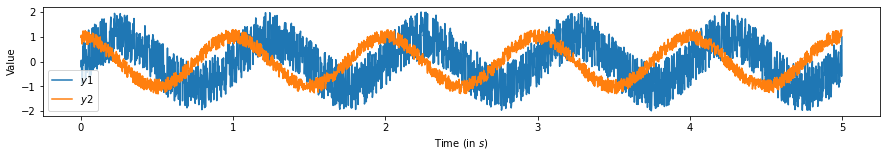

In [3]:
samp_rate = 500  # Sampling Frequency in Hertz
dur = 5  # Duration in Seconds

amp1 = 1  # Amplitude of Sine Wave 1
freq1 = 1  # Frequency of Sine Wave 1

amp2 = 1  # Amplitude of Sine Wave 2
freq2 = 1  # Frequency of Sine Wave 2

phase_shift = np.pi/2  # Phase shift
noise = np.random.uniform(-1, 1, samp_rate*dur)
x1, y1 = sine_wave(amp1, freq1, samp_rate, dur, noise=noise,
                   plot=False)
noise = np.random.uniform(-0.3, 0.3, samp_rate*dur)
x2, y2 = sine_wave(amp2, freq2, samp_rate, dur, noise=noise,
                   shift=phase_shift, plot=False)

plt.subplots(figsize=(15, 2))
plt.plot(np.linspace(0, dur, samp_rate*dur), y1, label='$y1$')
plt.plot(np.linspace(0, dur, samp_rate*dur), y2, label='$y2$')
plt.ylabel('Value')
plt.xlabel('Time (in $s$)')
plt.legend();

Maximum at: 0.23 (in $s$)


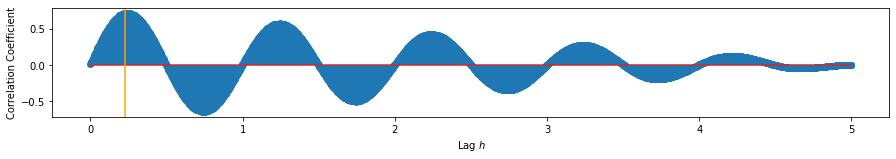

In [4]:
plt.subplots(figsize=(15, 2))

ccf_12 = ccf(y1, y2, unbiased=False)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag $h$')
plt.stem(np.linspace(0, dur, samp_rate*dur), ccf_12)
peak = np.argmax(ccf_12)/samp_rate
plt.axvline(peak, c='orange')
print('Maximum at:', peak, '(in $s$)')

We find that the maximum correlation between $y_2$ and $y_1$ occurs at ~0.247 seconds, approximately 1/4 of the frequency. This is very close to the theoretical value of 0.25 seconds corresponding to a phase shift of $\frac{\pi}{2}$. Using only direct measurements from the data, albeit synthetic, we are able to retrieve a reasonable estimate of the lag and delay between them.

By measuring the cross-correlation between these two signals we can find how far apart we need to adjust the time series to maximize their linear correlation. It is important to note that unlike the different causality measures discussed (Granger, Convergent Cross-mapping, etc.), cross-correlation does **not** give insights into causality - rather it only gives correlations.

### Example 1: Cross-Correlations in the Jena Climate Data

Let us look at how cross-correlations can be used to unearth relationships in real data. We will again use the Jena Climate Dataset to analyze the average temperature. This time, we will look at the relationship between daily temperature and daily wind speed.

In [5]:
df = pd.read_csv('../data/jena_climate_2009_2016.csv')
display(df.head())
data = df.iloc[:, 1:].astype(float).to_numpy()
temp = data[:, 1][::144]  # Temperature (in degrees Celsius) at one sample/day
wind = data[:, 10][::144]  # Wind Speed (in m/s) at one sample/day
dur = len(temp)
samp_rate = 1

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


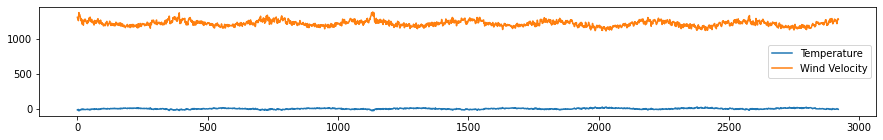

In [6]:
plt.subplots(figsize=(15, 2))
plt.plot(range(len(temp)), temp, label='Temperature')
plt.plot(range(len(wind)), wind, label='Wind Velocity')
plt.legend();

We rescale the graphs so that we can easily visualize them.

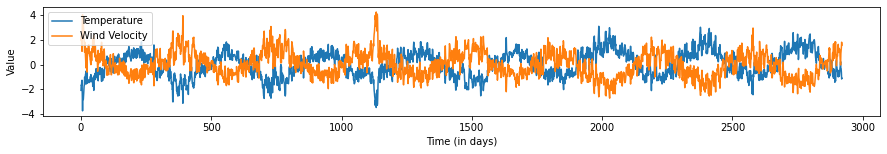

In [7]:
plt.subplots(figsize=(15, 2))
plt.plot(range(len(temp)), (temp-np.mean(temp)) /
         np.std(temp), label='Temperature')
plt.plot(range(len(wind)), (wind-np.mean(wind)) /
         np.std(wind), label='Wind Velocity')
plt.ylabel('Value')
plt.xlabel('Time (in days)')
plt.legend();

From previous chapters, we know that these time series are stationary. With stationarity, we can proceed with applying the CCF to these two time series.

Maximum at: 178.0 (in $s$)


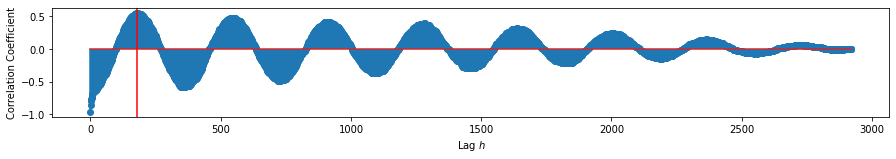

In [8]:
plt.subplots(figsize=(15, 2))

ccf_12 = ccf(temp, wind, unbiased=False)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag $h$')
plt.stem(np.linspace(0, dur, samp_rate*dur), ccf_12)
peak = np.argmax(ccf_12)/samp_rate
plt.axvline(peak, c='r')
print('Maximum at:', peak, '(in $s$)')

We find that the shift maximizing the correlation between the daily values of temeperature and wind speed are 178 samples. An interesting result is that the correlation at $s=0$ is at a minimum. Both of these suggest that temperature and wind speed are periodic functions mirror each other in that when one is maximized, the other is minimized. We estimate then that the wind speed leads the temperature values by 178 days. 

It should be noted that unlike Granger Causality which also draws relationships between multiple time series, cross-correlation does not provide us with the causality between the two. At best, cross-correlation shows the synchronocity between two time series.

### Example 2: Cross-Correlations Between Precipitation and Flow in the Sudbury River


We apply cross-correlation analysis on the daily stream flow of a river and the precipitation in its surrounding area. The data will be coming from the United States Geological Survey's (USGS) Real-time Water Data for the Nation and covers the Subdury River at Saxonville, Massachusetts for the year 2000. It comprises of the daily mean flow of water measured by the the USGS station. Understanding the causes and dynamics of flow in this specific river can have profound implications on managing the integity and diversity of its ecosystem.

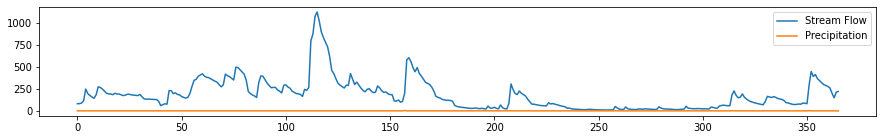

In [9]:
flow_df = pd.read_csv('../data/cc/flowsud_2000.txt', sep='\t')
flow_df.columns = ['USGS', 'site_no', 'datetime', 'flow', '-']

flow = flow_df['flow']

rain_df = pd.read_csv('../data/cc/weather_2000.txt')
rain_df['Prcp'] = rain_df['Prcp'].replace('T', 0.0005).astype(float)

rain = rain_df['Prcp']

dur = len(rain)
samp_rate = 1

plt.subplots(figsize=(15, 2))
plt.plot(flow, label='Stream Flow')
plt.plot(rain, label='Precipitation')
plt.legend();

Once again, we rescale the graphs so that we can easily visualize them.

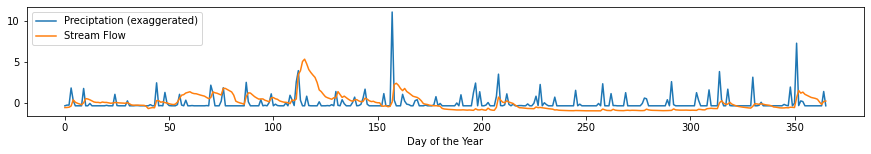

In [10]:
plt.subplots(figsize=(15, 2))
plt.plot((rain-np.mean(rain))/np.std(rain), label='Preciptation (exaggerated)')
plt.plot((flow-np.mean(flow))/np.std(flow), label='Stream Flow')
plt.xlabel('Day of the Year')
plt.legend();

We perform the Augmented Dickey-Fuller test on the two time series to figure out if they are stationary. If they are indeed stationary, we can proceed to performing the cross-correlation.

In [11]:
result = adfuller(flow)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.878838
p-value: 0.002196
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


In [12]:
result = adfuller(rain)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.494992
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Both time series are stationary and we proceed with applying the CCF.

Maximum at: 1.0 (in $days$)


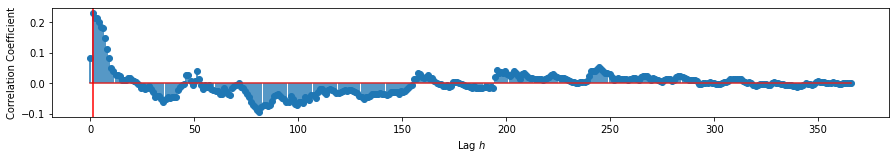

In [13]:
plt.subplots(figsize=(15, 2))

ccf_12 = ccf(flow, rain, unbiased=False)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag $h$')
plt.stem(np.linspace(0, dur, samp_rate*dur), ccf_12)
peak = np.argmax(ccf_12)/samp_rate
plt.axvline(peak, c='r')
print('Maximum at:', peak, '(in $days$)')

We find that the maximum correlation happens when precipitation leads stream flow by 1 day. While cross-correlation alone cannot give us causality, understanding of the measurements involved can be used to argue such. In the case of rainfall and precipitation, there is established understanding that precipitation leads to increases in river flow. We can conclude with some confidence that precipitation will cause an increase in river flow after 1 day.

To supplement our analysis, we move into the frequency domain with the Fourier Transform by first understanding the Fourier Series.

## The Fourier Series:

Any periodic signal can be broken down into a summation of sine and cosine waves. A periodic time series $X(t)$ can be broken down into fundamental frequencies given by the Fourier Series:

$\begin{align} y(t) = \frac{a_0}{2}  + \sum_{n=1}^{\infty}{a_n cos(nt)) + b_n sin(nt)} \end{align}$

Integrating both sides by $\int+{-\pi}^{\pi} cos(mt)dt$ where $m$ is an integer:

$\begin{align} \int_{-\pi}^{\pi}{y(t)cos(mt)dt} = \frac{1}{2} a_0 + \sum_{n=1}^{\infty}{\int_{-\pi}^{\pi}a_n cos(nt)cos(mt)dt + \sum_{n=1}^{\infty}\int_{-\pi}^{\pi}b_n sin(nt) cos(mt)dt} \end{align}$

Via orthogonality between $cos$ and $sin$ over $[-\pi,\pi]$:

$\begin{align} \int_{-\pi}^{\pi}{cos(nt)cos(mt)dt} = 0,   m\neq n \end{align}$
$\begin{align} \int_{-\pi}^{\pi}{sin(nt)cos(mt)dt} = 0,   all m,n \end{align}$
$\begin{align} \int_{-\pi}^{\pi}{cos(nt)sin(mt)dt} = 0,   m\neq n \end{align}$

Equation 4 reduces to:

$\begin{align} \int_{-\pi}^{\pi}{y(t)cos(mt)dt} = a_m \int_{-\pi}^{\pi}cos^{2}(mt)dt \end{align}$

Solving for this a_m, we find that:

$\begin{align} a_m = \frac{1}{\pi}\int_{-\pi}^{\pi}{y(t) cos(mt)dt} \end{align}$

Doing the same for b_m, we find the similar coefficient:

$\begin{align} b_m = \frac{1}{\pi}\int_{-\pi}^{\pi}{y(t) sin(mt)dt} \end{align}$

for $n =0,1,2...,$ where:

$n = 0$ is the constant component of the signal

$n = 1$ is the \textit{fundamental} corresponding to a sine/cosine wave whose period matches $y(t)$'s period exactly

$n = 2$ is the first harmonic corresponding to a sine/cosine whose period matches $\frac{1}{2}$ of $y(t)$'s period

$n = 3$ is the second harmonic corresponding to a sine/cosine whose period matches $\frac{1}{3}$ of $y(t)$'s period


One useful quantity to look at is the energy of a signal as it tells us how "much" of a signal there is. We define a single coefficient $c_n^{2}$ to describe the "energy" of a signal at a specific frequency where $c_n$ is given by:

$\begin{align}c_n = \left[\frac{1}{2}(a^2_n + b^2_n)\right]^{\frac{1}{2}}\end{align}$

The square of these coefficients ($c_n^{2}$) corresponds to the energy of a certain frequency $n$.

## The Fourier Transform:

Transforming a signal from the time domain into the frequency ($\omega$) domain using this method is called the \textbf{Fourier Transform (FT)}. The FT is given by:

\begin{align} \hat{y}(\omega) = \int_{-\infty}^{\infty}{y(t)e^{-2\pi i \omega t}d\omega} \end{align}

To better understand the FT, let us take a look at some of its applications.

### FT of a Pure Signal

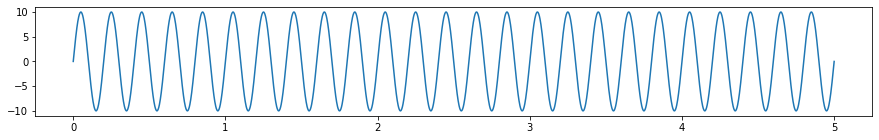

In [14]:
samp_rate = 500  # Sampling Frequency in Hertz
dur = 5  # Duration in Seconds
amp = 10  # Amplitude of Sine Wave
freq = 5  # Frequency of Sine Wave
x, y = sine_wave(amp, freq, samp_rate, dur, plot=True)

Let's work with ideal conditions first. Let's apply the Fourier Transform on the single sine wave with frequency of 5 Hz.

Peak at: 5.0 Hz


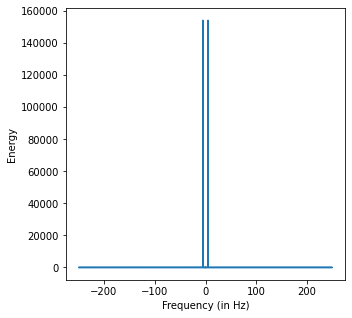

In [15]:
y_ft = scp.fft.fft(y)
freqs = scp.fft.fftfreq(x.shape[-1])*samp_rate
plt.subplots(figsize=(5, 5))
plt.plot(freqs, y_ft.real**2)
plt.ylabel('Energy')
plt.xlabel('Frequency (in Hz)')
print('Peak at:', np.argmax(y_ft.real**2)/dur, 'Hz')

We see two peaks when the frequency is 5 and -5.

The left-hand side corresponds to negative frequencies. Physically, negative frequencies are not very meaningful but their presence is important in calculating for the Fourier Transform. By finding where the energy peaks, we can find frequencies that best describe the time series.

Additionally, the FT is a perfectly (to numerical precision) reversible process. By knowing the energies of each frequency, we can retrieve the original signal by performing an \textbf{Inverse Fourier Transform (IFT)}.

Is close: True


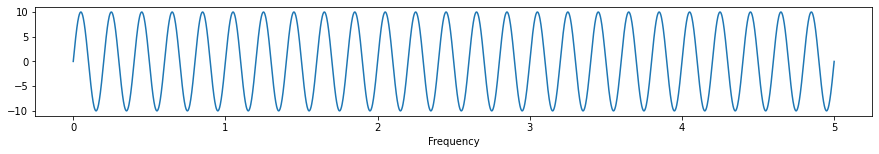

In [16]:
plt.subplots(figsize=(15, 2))
plt.plot(x, scp.fft.ifft(y_ft).real)
plt.xlabel('Frequency')
print("Is close:", np.allclose(scp.fft.ifft(y_ft), y))

### FT on Mixed Signals

An important use of the FT is analyzing signals with mixed frequencies. We can perform the above exercise on 2 combined waves (or even an arbitrary number of waves with differing frequencies!) to find which frequencies are present in our signal.

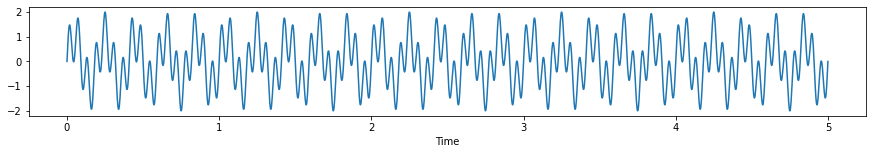

In [17]:
samp_rate = 500  # Sampling Frequency in Hertz
dur = 5  # Duration in Seconds

amp1 = 1  # Amplitude of Sine Wave 1
freq1 = 5  # Frequency of Sine Wave 1

amp2 = 1  # Amplitude of Sine Wave 2
freq2 = 17  # Frequency of Sine Wave 2

x1, y1 = sine_wave(amp1, freq1, samp_rate, dur, plot=False)
x2, y2 = sine_wave(amp2, freq2, samp_rate, dur, plot=False)
y = y1 + y2  # Simply overlapping the two signals
plt.subplots(figsize=(15, 2))
plt.xlabel('Time')
plt.plot(x1, y);

Eyeballing the graph, it is challenging to determine its exact frequency make up.

Peaks at: [ 5. 17.]


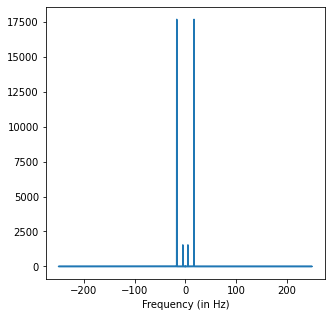

In [18]:
y_ft = scp.fft.fft(y)
freqs = scp.fft.fftfreq(x1.shape[-1])*samp_rate

plt.subplots(figsize=(5, 5))
plt.plot(freqs, y_ft.real**2)
plt.xlabel('Frequency (in Hz)')
peaks = scp.signal.find_peaks(y_ft.real**2)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
print('Peaks at:', peak_vals)

The FT makes it very easy to find the frequencies of the signal even if they are mixed.

## Noise Filtering

Real time series data are never free from noise making it tricky to find the real dynamics of whatever it is measuring. We may end up trying to model noise and end up overlooking the real behavior of the time series.


Thankfully, we can manipulate time series data in the frequency domain to eliminate one of the most types of noise - white noise. White noise pervades time series data and by definition, has components across all frequencies. Usually, a time series with white noise is represented as:

\begin{align} y(t) = s(t) + v(t) \end{align}

where $s(t)$ is the true signal we want to retrieve from $y(t)$ and $v(t)$ is white noise we want to eliminate. We simulate this below by adding white noise to the signal.

### Filtering by Energy Level

White noise is characterized by having energy levels almost equal for all frequencies. Such a signal can be generate by simply using a random number generator.

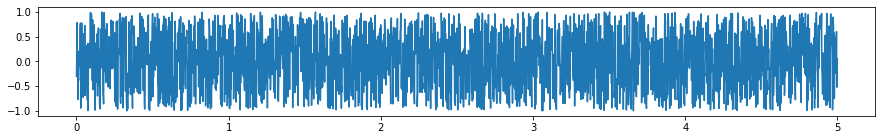

In [19]:
noise = np.random.uniform(-1,1, len(y))
plt.subplots(figsize=(15, 2))
plt.plot(x1, noise);

Taking the FT of the white noise, we find that indeed, for almost all the frequencies, there are positive energy values for them all. This means that for all frequencies, the white noise will have some contribution which can affect our analysis of the time series.

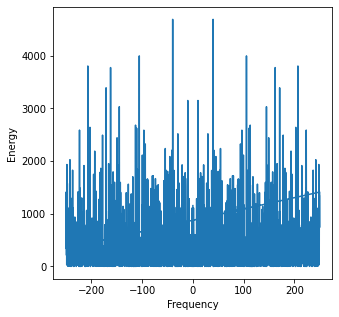

In [20]:
noise_ft = scp.fft.fft(noise)
freqs = scp.fft.fftfreq(x1.shape[-1])*samp_rate
peaks = scp.signal.find_peaks(noise_ft.real**2)

plt.subplots(figsize=(5, 5))
plt.plot(freqs, noise_ft.real**2)
plt.ylabel('Energy')
plt.xlabel('Frequency');

The addiiton of white noise to the mixed frequency signal makes its actual behavior less observable. The white noise has "corrupted" the signal and presents a challenge we find when making any measurement. How can we sift out the original mixed signal when the data we receive is noisy?

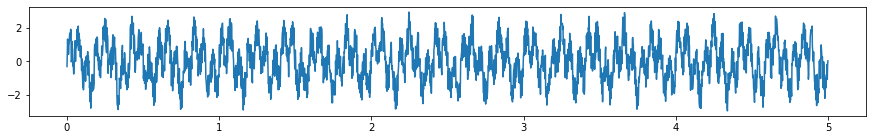

In [21]:
y_noisy = y+noise
plt.subplots(figsize=(15, 2))
plt.plot(x1, y_noisy);

The resulting FT of the noisy signal results in multiple peaks being found. This poses a problem if we are trying to find the appropriate periodic trends in our data. Luckily, the noise appears to be present only at low energy levels. Should measurements have been done reasonably well in collecting this data, noise can be managed as they only have low energy levels.

Peaks at: [  0.6   1.2   1.6   2.8   4.    5.    5.4   6.    6.6   7.4   8.    8.4
   9.2  10.   10.6  11.   11.6  12.6  13.2  13.8  14.4  15.2  16.   16.4
  17.   17.4  17.8  18.4  19.   19.6  20.   20.4  21.2  21.6  22.   22.4
  23.   23.8  24.8  25.2  25.6  26.   26.6  27.2  27.8  28.2  28.8  29.6
  30.   30.8  31.2  31.8  33.   34.2  34.6  35.   35.4  35.8  36.4  37.
  37.8  38.4  39.2  39.8  40.2  40.6  41.2  41.8  42.2  43.   43.6  44.
  44.8  45.4  46.2  46.6  47.2  47.6  48.   48.6  49.2  49.8  50.2  50.6
  51.   51.4  52.   52.6  53.   53.6  54.   54.4  54.8  55.2  55.8  56.4
  57.   57.6  58.6  59.   59.4  60.   60.8  61.6  62.2  62.6  63.2  63.8
  64.4  65.   65.4  65.8  66.2  66.8  67.6  68.   68.4  69.2  69.6  70.
  71.2  71.6  72.6  73.   73.4  73.8  74.6  75.2  76.   76.6  77.2  77.6
  78.2  78.6  79.4  79.8  80.2  80.6  81.2  81.8  82.2  82.6  83.   84.
  84.8  85.2  85.6  86.4  86.8  87.2  88.2  88.6  89.4  90.2  91.   91.4
  91.8  92.2  93.   93.8  94.4  94.8  95.8  9

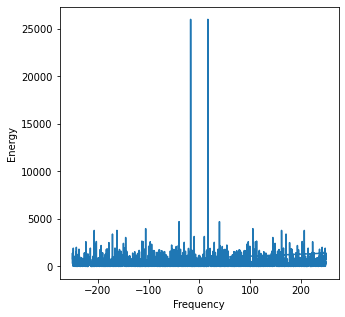

In [22]:
y_ft = scp.fft.fft(y_noisy)
freqs = scp.fft.fftfreq(x1.shape[-1])*samp_rate
peaks = scp.signal.find_peaks(y_ft.real**2)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
print('Peaks at:', peak_vals)

plt.subplots(figsize=(5, 5))
plt.plot(freqs, y_ft.real**2)
plt.ylabel('Energy')
plt.xlabel('Frequency');

In crude fashion, we can set a hard threshold that removes the coefficients of frequencies below a certain energy level . One way to accomplish this is by setting the cut-off as a multiple of the standard deviation. The Fourier Transform allows us to make such 

\textit{Conversely, we can perform the same method to eliminate high energy signals or even select those in a certain band}  

In [23]:
threshold = 3*np.std(y_ft.real)
peaks = scp.signal.find_peaks(y_ft.real, threshold=threshold)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
print('Peaks at:', peak_vals)

Peaks at: [ 17.  149.4 202.8 207. ]


By visual inspection and setting an arbitrary threshold of 3x the standard deviation, we are able to retrieve a clearer signal of the dominant frequencies, albeit with the likely addiiton of some stray frequencies. Obtaining the exact signal from a noisy one can be very difficult but with judicious application and an understanding of the underlying systme, filtering by energy levels can be a quick and effective way to modify your time series.

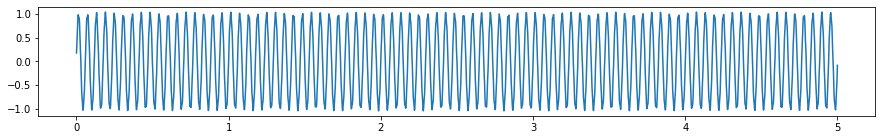

In [24]:
y_ft_denoised = [0 if x < threshold else x for x in y_ft]
plt.subplots(figsize=(15, 2))
y_denoised = scp.fft.ifft(y_ft_denoised)
plt.plot(x1, y_denoised.real);

### Filtering by Frequency

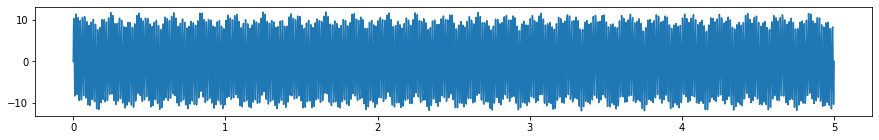

In [25]:
hf_noise = sine_wave(amp, 70, samp_rate, dur, plot=False)[1]

y_hf_noisy = y+hf_noise
plt.subplots(figsize=(15, 2))
plt.plot(x, y_hf_noisy);

Observing the FT of a signal with high frequency noise, the noise dominates the energy spectrum and masks the underlying signal.

Peaks at: [ 5. 17. 70.]


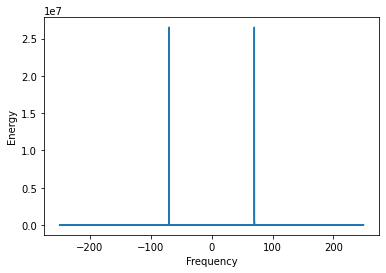

In [26]:
y_ft_hf = scp.fft.fft(y_hf_noisy)
freqs = scp.fft.fftfreq(x.shape[-1])*samp_rate
plt.plot(freqs, y_ft_hf.real**2)
peaks = scp.signal.find_peaks(y_ft_hf.real)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
plt.ylabel('Energy')
plt.xlabel('Frequency')
print('Peaks at:', peak_vals)

While the loewr frequency peaks of the signal can still be retrieved, the extreme noise will make it untenable for most forecasting purposes. These high frequencies* can be eliminated to retrieve the original signal. Guided by our desire to observe the signals that exhibit lower frequencies, we can force the energies of all frequencies above a desired threshold to 0 and perform the IFT to obtain the 

\textbf{*}\textit{We can do the same for low frequencies and those in a "band".} 

In [27]:
freqs = scp.fft.fftfreq(x.shape[-1])*samp_rate
freqs

array([ 0. ,  0.2,  0.4, ..., -0.6, -0.4, -0.2])

Peaks at: [ 5. 17.]


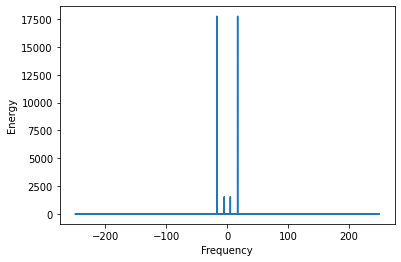

In [28]:
f_thresh = 20

freqs = scp.fft.fftfreq(x.shape[-1])*samp_rate
y_ft_hf_filtered = y_ft_hf.copy()
y_ft_hf_filtered[(abs(freqs.real) > f_thresh)] = 0

plt.plot(freqs, y_ft_hf_filtered.real**2)
plt.ylabel('Energy')
plt.xlabel('Frequency');
peaks = scp.signal.find_peaks(y_ft_hf_filtered.real)
peak_vals = peaks[0][:len(peaks[0])//2]/dur
print('Peaks at:', peak_vals)

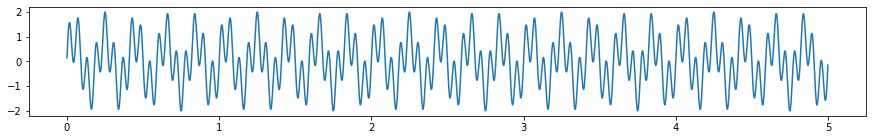

In [29]:
plt.subplots(figsize=(15, 2))
y_lf = scp.fft.ifft(y_ft_hf_filtered).real
plt.plot(x1, y_lf.real);

### Example 3: Filtering via FT in the Jena Climate Dataset

Looking at climate information, we can glean insights into the seasonality of climate patterns. Let's examine the mean daily temperature of the Jena climate dataset and apply FT to examine its seasonality.

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


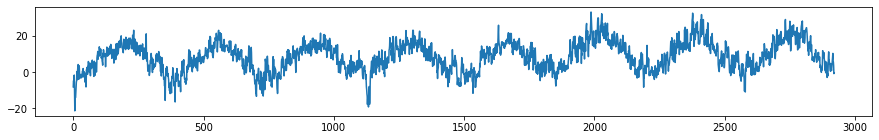

In [30]:
df = pd.read_csv('../data/jena_climate_2009_2016.csv')
display(df.head())
df['Date Time'] = pd.to_datetime(
    df['Date Time'], dayfirst=True, format="%d.%m.%Y %H:%M:%S")
df['Date'] = df['Date Time'].dt.date
mean_temps = df.groupby('Date')['T (degC)'].mean().values
plt.subplots(figsize=(15, 2))
plt.plot(temp)

There is a very strong trend that can be seen every year. Suppose we want to examine only this trend as we are interested in the general dynamics of the system. To highlight that aspect of the time series, we filter out frequencies corresponding to greater than 1 year by setting their energies to 0.

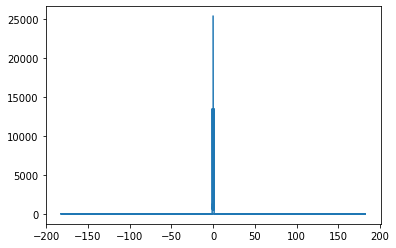

In [31]:
y_ft = scp.fft.fft(temp)
y_ft_copy = y_ft.copy()
freqs = scp.fft.fftfreq(len(temp), d=1/365)
y_ft_copy[(abs(freqs) >= 1)] = 0
plt.plot(freqs, abs(y_ft_copy))

By removing all frequencies greater than 1 year, we obtain only the lower frequency values. With these values, we can have a better look at the yearly dynamics of daily temperature without interference from inter-year dynamics. Should forecasts on actual values of the temperature need to be made, the value sof the frequencies removed can simply be added back.

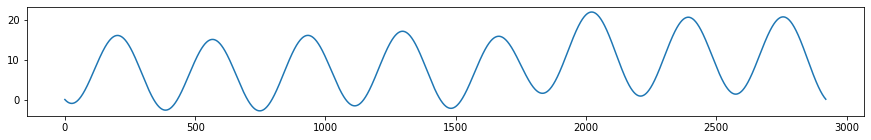

In [32]:
y_hf = scp.fft.ifft(y_ft_copy)
plt.subplots(figsize=(15, 2))
# plt.title('Removing Yearly Cycle')
plt.plot(range(len(temp)), y_hf.real)

## Wavelet Transform

A wavelet transform (WT) allows you to measure how "much"of a certain type of wavelet there exists in a given signal. While both FT and WT both transform a time series into the frequency domain, a key difference is that WT gives you information about the time domain as well.

This transformation is achieved by imagining a specified wavelet sliding it across the entire signal through time. This wavelet that we scan is called the "mother wavelet". In addition to sliding the mother Wavelet across the span of the time series, its size, dependent on a scale factor, is varied as well while scanning. The scaling transformation applied on the mother Wavelet can be thought of as "stretching" it only without changing its frequency.

The wavelet transform of a time series $y(t)$ is given by:

$\begin{align} WT(y(t)) = \frac{1}{\sqrt{|\sigma|}}\int_{-\infty}^{\infty}y(t)\psi \left( \frac{t-h}{\sigma} \right)dt \end{align}$

where $\sigma$ is the scale, $h$ is the time lag/translation, and $\psi$ is the mother wavelet. 

From the WT, we obtaing sets of coefficients corresponding to different time lags and scales. The greater the magnitude of the coefficients, the greater overlap there is between the scaled, time-shifted mother wavelet and the time series.

In [33]:
def rescale(arr, scale=2):
    n = len(arr)
    return np.interp(np.linspace(0, n, scale*n+1), np.arange(n), arr)

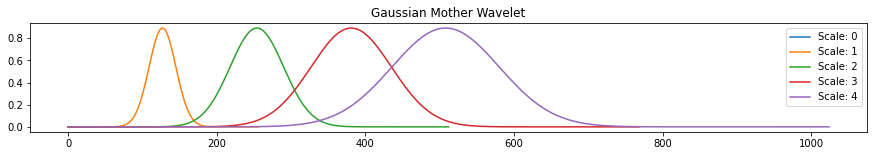

In [34]:
fig, ax = plt.subplots(figsize=(15, 2))
wav1 = pywt.ContinuousWavelet('gaus1')
int_psi1, x = pywt.integrate_wavelet(wav1)
for s in range(5):
    ax.plot(rescale(int_psi1, scale=s), label='Scale: '+ str(s))
    ax.legend()
    ax.set_title('Gaussian Mother Wavelet')

Suppose we have a signal of repearing Gaussian waves. Applying the WT on this signal using a mother wavelet corresponding to that of a Gaussian wavelet, we can pinpoint where the time series exhibits a Gaussian-like pattern.

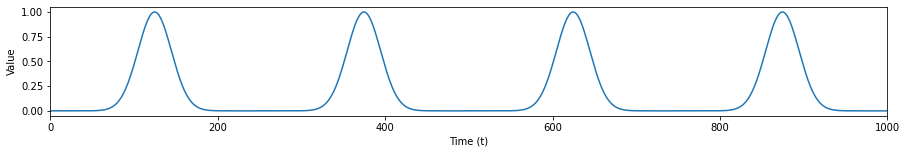

In [35]:
s1 = list(scp.signal.gaussian(250, std=20))
s1 = np.tile(s1, 4)
plt.subplots(figsize=(15, 2))
plt.xlim(left=0, right=1000)
plt.ylabel('Value')
plt.xlabel('Time (t)')
plt.plot(s1)
plt.show()

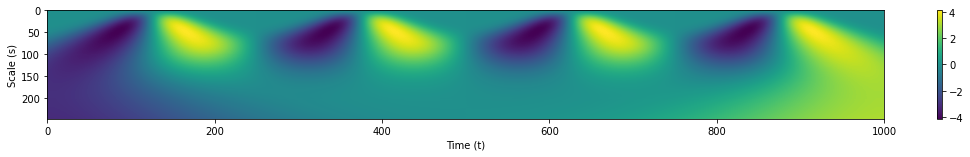

In [36]:
coeffs, freqs = pywt.cwt(s1, range(1,250), wavelet='gaus1')
plt.subplots(figsize=(18.75, 2))
plt.xlim(left=0, right=1000)
plt.ylabel('Scale (s)')
plt.xlabel('Time (t)')
plt.imshow(coeffs, aspect='auto')
plt.colorbar();

By observing where the magnitudes of the WT are greatest, we can pinpoint the time and scale wherein there is Gaussian-like behavior in our time series. The WT is also useful in sifting out our signal from noise. We apply white noise once more to our Gaussian pulses and observe the WT's results.

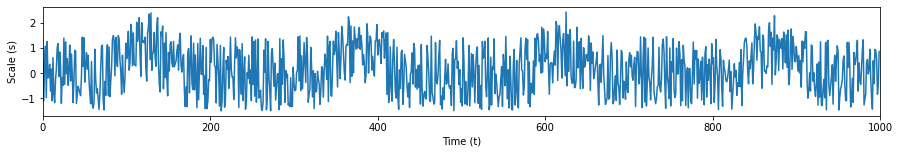

In [37]:
s1 = list(scp.signal.gaussian(250, std=20))
noise = np.random.uniform(-1.5,1.5,4*len(s1))
s1 = np.tile(s1, 4) + noise
plt.subplots(figsize=(15, 2))
plt.xlim(left=0, right=1000)
plt.ylabel('Scale (s)')
plt.xlabel('Time (t)')
plt.plot(s1)
plt.show()

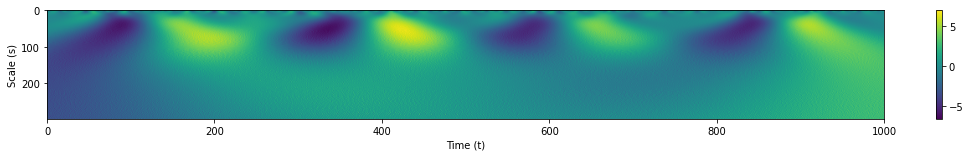

In [38]:
coeffs, freqs = pywt.cwt(s1, range(1,300), wavelet='gaus1')
plt.subplots(figsize=(18.75, 2))
plt.xlim(left=0, right=1000)
plt.ylabel('Scale (s)')
plt.xlabel('Time (t)')
plt.imshow(coeffs, aspect='auto')
plt.colorbar();

Regions of high magnitudes for our WT coefficients are still clearly visible albeit with minior interference from the white noise at smaller scales. 

In general, choosing the mother wavelet depends on what kind of behavior you want or expect in your time series. Another popular mother wavelet used to identify sine waves in time series is the "Morlet" wavelet. This wavelet is a sine wave tapered by a Gaussian wave.

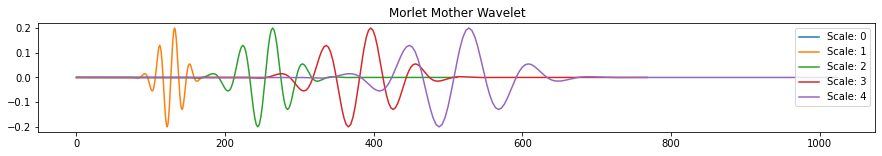

In [39]:
fig, ax = plt.subplots(figsize=(15, 2))
wav2 = pywt.ContinuousWavelet('morl')
int_psi2, x = pywt.integrate_wavelet(wav2)
for s in range(5):
    ax.plot(rescale(int_psi2, scale=s), label='Scale: '+ str(s))
    ax.set_title('Morlet Mother Wavelet')
    ax.legend()

Applying the Morlet wavelet on a mixed frequency sinusoidal signal, we can find that it is able to differentiate between the two frequencies as $s$ is varied.

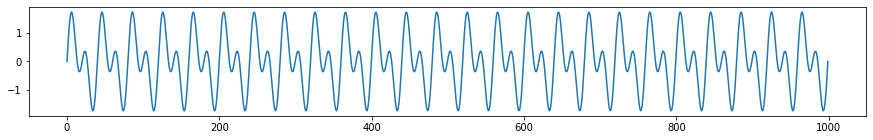

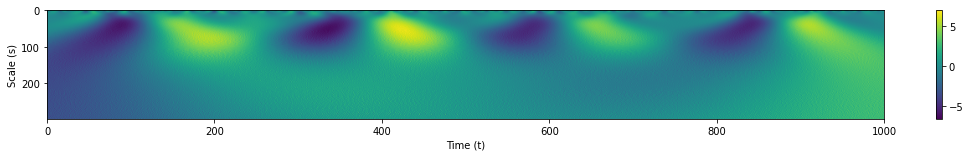

In [40]:
sine5 = sine_wave(freq=5, duration =5, plot=False)[1]
sine10 = sine_wave(freq=10, plot=False)[1]
sine_5_10 = sine5+sine10
plt.subplots(figsize=(15, 2))
plt.plot(sine_5_10)
plt.show()
plt.subplots(figsize=(18.75, 2))
plt.xlim(left=0, right=1000)
plt.ylabel('Scale (s)')
plt.xlabel('Time (t)')
plt.imshow(coeffs, aspect='auto')
plt.colorbar();

### Example: 4 Using Accelerometer and Gyroscopic Data

The following code is taken from:

https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442

The following data contains time signals of accelerometer and gyroscopic data attached to people performing different activities. Throughout the duration of their activity, measurements were taken from the devices and recorded as time series. Each time series depicts a different activity.

In [43]:
def load_y_data(y_path):
    y = np.loadtxt(y_path, dtype=np.int32).reshape(-1, 1)
    # change labels range from 1-6 t 0-5, this enables a sparse_categorical_crossentropy loss function
    return y - 1


def load_X_data(X_path):
    X_signal_paths = [X_path + file for file in os.listdir(X_path)]
    X_signals = [np.loadtxt(path, dtype=np.float32) for path in X_signal_paths]
    return np.transpose(np.array(X_signals), (1, 2, 0))


PATH = '../data/cwt/'
LABEL_NAMES = ["Walking", "Walking upstairs",
               "Walking downstairs", "Sitting", "Standing", "Laying"]

# load X data
X_train = load_X_data(PATH + 'train/Inertial Signals/')
X_test = load_X_data(PATH + 'test/Inertial Signals/')
# load y label
y_train = load_y_data(PATH + 'train/y_train.txt')
y_test = load_y_data(PATH + 'test/y_test.txt')

Quite evidently, we find that walking has a different "look" from that of simply laying down. Humans can easily determine this at a glance but can be difficult for machines to differentiate between the two signals. The WT allows for the creation of images that contain temporal and frequency information providing a compact and meaningful representation of these time series.

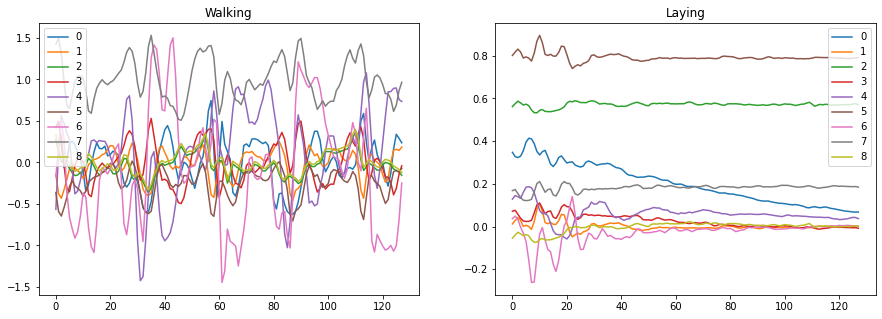

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
pd.DataFrame(X_train[79]).plot(ax=ax[0], title='Walking')
pd.DataFrame(X_train[51]).plot(ax=ax[1], title='Laying');

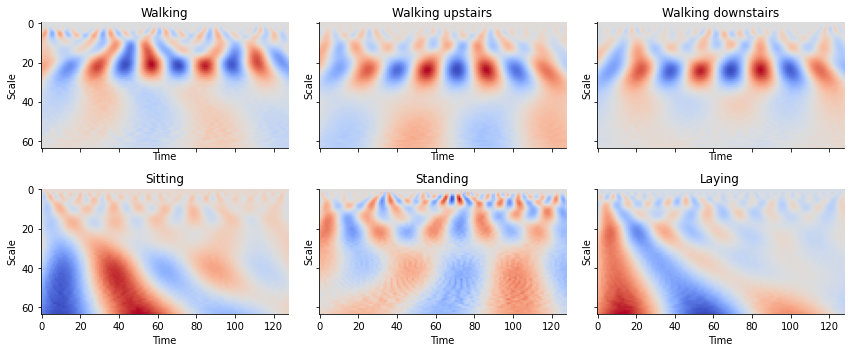

In [45]:
def split_indices_per_label(y):
    indicies_per_label = [[] for x in range(0, 6)]
    # loop over the six labels
    for i in range(6):
        indicies_per_label[i] = np.where(y == i)[0]
    return indicies_per_label


def plot_cwt_coeffs_per_label(X, label_indicies, label_names, signal, sample, scales, wavelet):

    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True,
                            sharey=True, figsize=(12, 5))

    for ax, indices, name in zip(axs.flat, label_indicies, label_names):
        coeffs, freqs = pywt.cwt(
            X[indices[sample], :, signal], scales, wavelet=wavelet)
        ax.imshow(coeffs, cmap='coolwarm', aspect='auto')
        ax.set_title(name)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')
    plt.tight_layout()


train_labels_indicies = split_indices_per_label(y_train)

# signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 3  # signal index
sample = 1  # sample index of each label indicies list
scales = np.arange(1, 65)  # range of scales
wavelet = 'morl'  # mother wavelet

plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES, signal,
                          sample, scales, wavelet)

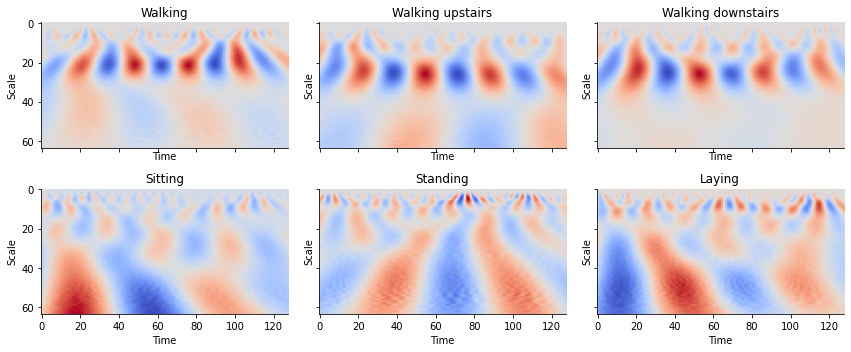

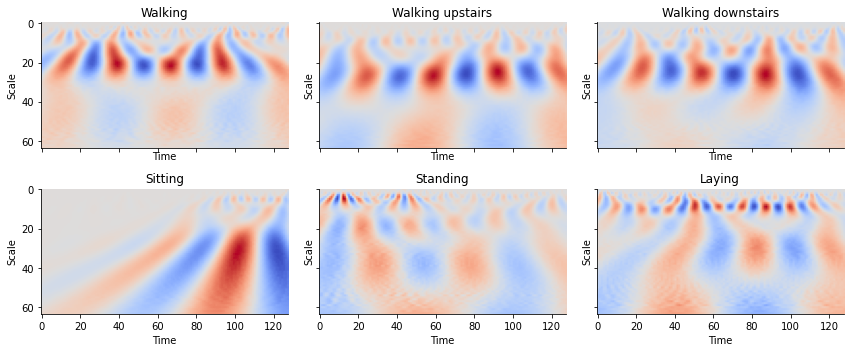

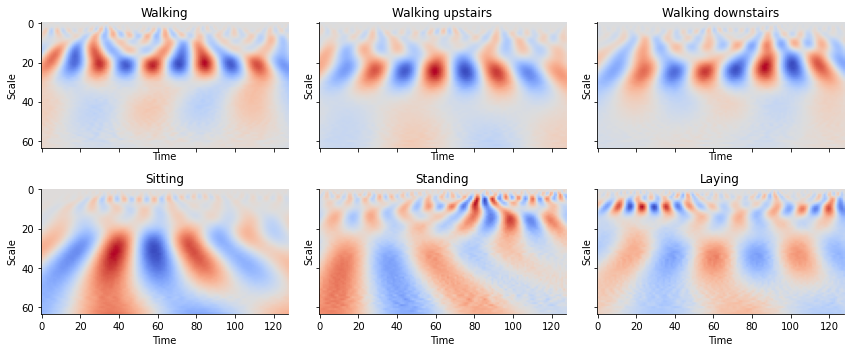

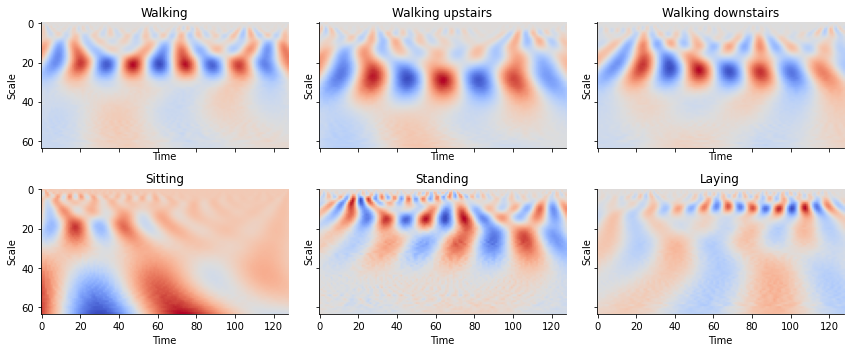

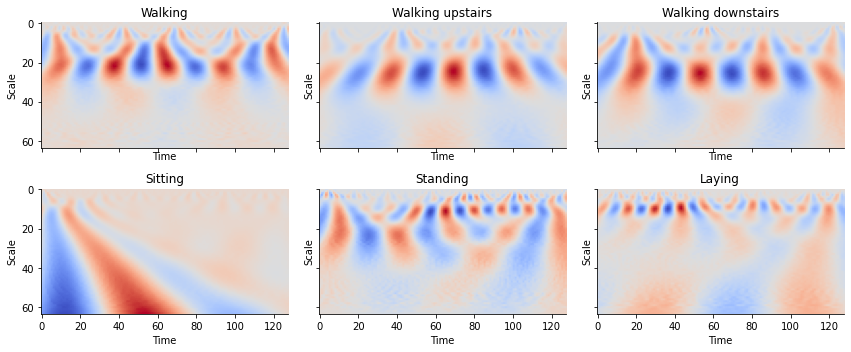

In [46]:
for sample in range(2, 7):
    plot_cwt_coeffs_per_label(X_train, train_labels_indicies, LABEL_NAMES,
                              signal, sample, scales, wavelet)

Looking at the plots for each activity, we see can see some patterns between the images. By feeding these results into a convolutional neural network, we can create a classifier to classify time series into activities.

## Summary


To summarize, using these techniques can extract valuable information about time series which are not readily available.

Cross-correlations can give insights into the sychronicity of data. With careful analysis, these can even be used as a step towards a more holistic view of causality in conjunction with Granger Causality and Convergent Cross Mapping.

Fourier Transformation allows us to view the time series in the frequency domain, allowing operations previously untenable in the time domain. Filtering is a common task where FT is useful as it lets us easily manipulate the data to remove noise or highlight aspects of interest within the time series.


Wavelet Transformation lets us decompose time series more finely than the FT since we can define the "mother" wavelet to be our wavefunction of interest. By characterizing time series, we can quite literally, paint a picture of the time series that can be used to pick out specific waveforms in the time series.

In the context of forecasting, all three techniques can be used to inform the modeler how to prepare their data. With cross-correlations, the best time lagged time series can be used to provide better information about the target. The Fourier Transform can be applied to denoise the data and remove certain trends. Wavelet Transforms can be used to classify time series allowing the modeler to include their classification as a feature for forecasting or creating separate models for each class of time series. Again, these techniques serve as complements to predictive methods and can be used as feature engineering techniques to improve time series forecasing.

The following chapter represents the culmination of all the forecasting concepts from previous sections. There is no better way to test your time series capabilities than with a competition. The next chapter discusses the best techniques which were utilized in the recently concluded M5 Competition. In it, the best models under some constraints, are pushed to the limit to perform time series forecasting.

## References

The contents of this notebook are complied from the following references:

 *  Chapters 1-3 of Priestley, M.B. (1981). Spectral Analysis and Time Series, Vols. 1 and 2, Academic Press, New York.

 * <a href='https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442'>Multiple Time Series Classification by Using Continuous Wavelet Transformation</a>
 
 * <a href='https://pywavelets.readthedocs.io/en/latest/'>PyWavelets Documentation</a>
 
 * <a href='https://www.mathworks.com/help/wavelet/gs/interpreting-continuous-wavelet-coefficients.html'>Interpreting Continuous Wavelet Coefficients</a>
 
 * 
Ngui, W. K., Leong, M. S., Hee, L. M., & Abdelrhman, A. M. (2013). Wavelet Analysis: Mother Wavelet Selection Methods. Applied Mechanics and Materials, 393, 953–958. https://doi.org/10.4028/www.scientific.net/amm.393.953